# Implementing Machine Learning Models to our Data

1. Data loading
2. Feature extraction and engineering
3. Model training and evaluation

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import time

## 1. Load the Data

In [3]:
import pandas as pd
dataset_df = pd.read_csv('../data/combined_cleaned_merged_dataset.csv')

### Remove stopwords from the text

In [4]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_stopwords(text: str) -> str:
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

def remove_caller_recipient(text: str) -> str:
    text = text.replace("caller: ", "")
    text = text.replace("recipient: ", "")
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fooyo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
dataset_df['dialogue_processed'] = dataset_df['dialogue'].apply(remove_stopwords)
dataset_df['dialogue_processed'] = dataset_df['dialogue_processed'].apply(remove_caller_recipient)

In [6]:
dataset_df.head()

,dialogue,labels,type,dialogue_processed
0,"caller: Hello, good morning. My name is Priya ...",1,Consumer & Retail Scams,"Hello, good morning. My name Priya 'Hope Child..."
1,"caller: Good morning, Madam Lee. My name is Ag...",1,Impersonation Scams,"Good morning, Madam Lee. My name Agent Tan Sin..."
2,"caller: Good morning, Mr. Lim. This is Inspect...",1,Impersonation Scams,"Good morning, Mr. Lim. This Inspector Wong Sin..."
3,"caller: Hello, is this Sarah Miller? recipient...",1,Loan & Debt Scams,"Hello, Sarah Miller? Yes, speaking. Hi Sarah, ..."
4,"caller: Hello, is this David Chen? recipient: ...",1,Loan & Debt Scams,"Hello, David Chen? Yes, speaking. Hi David, na..."


## 2. Feature Extraction and Engineering

### A summary of the dataset

Now, the dataset comprises of the following columns:

1. `dialogue` - The original combined phone call conversation
2. `labels` - Represents whether or not the conversation is likely (1) or unlikely (0) a scam call
3. `type` - The type/category of scam
4. `dialogue_processed` - The processed dialogue with the caller/recipient tag standardised
5. `caller_texts` - Only the caller's transcription derived from `dialogue_processed`
6. `recipient_texts` - The recipient's transcription derived from `dialogue_processed`

In [7]:
dataset_df.head()

,dialogue,labels,type,dialogue_processed
0,"caller: Hello, good morning. My name is Priya ...",1,Consumer & Retail Scams,"Hello, good morning. My name Priya 'Hope Child..."
1,"caller: Good morning, Madam Lee. My name is Ag...",1,Impersonation Scams,"Good morning, Madam Lee. My name Agent Tan Sin..."
2,"caller: Good morning, Mr. Lim. This is Inspect...",1,Impersonation Scams,"Good morning, Mr. Lim. This Inspector Wong Sin..."
3,"caller: Hello, is this Sarah Miller? recipient...",1,Loan & Debt Scams,"Hello, Sarah Miller? Yes, speaking. Hi Sarah, ..."
4,"caller: Hello, is this David Chen? recipient: ...",1,Loan & Debt Scams,"Hello, David Chen? Yes, speaking. Hi David, na..."


In [8]:
dataset_df['dialogue_processed'].iloc[0]

"Hello, good morning. My name Priya 'Hope Children Foundation'. How today? I'm well, thank you. How I help you? That's wonderful hear! We currently raising funds provide essential supplies support children affected recent floods Johor Bahru. The situation dire, many families lost everything. Oh, that's terrible! I heard floods. I'd like help I can. That's kind you, Mr. Tan. Every little bit helps. We've already assisted hundreds families, desperately need resources. We trying get potable water, food, medicine immediately. What kind support looking for? We accepting donations amount. Even small contribution make huge difference children's lives. We process donations credit debit cards. Okay, I donate. What information need? Thank much, Mr. Tan! To process donation, I'll need card number, expiry date, CVV. Alright, card number 4222333344445555, expiry date 07/25, CVV 789. Perfect, Mr. Tan. One moment I process that. Thank generous donation! You're making real difference. You're welcome. 

### Extract the 5-grams from both caller and recipient

From the EDA process, we understand that the 5-grams from both the caller and the recipient provide the most insights on the top phrases and words. We will now extract the 5-grams on a row basis for both the caller and recipient, and then vectorize them using scikit-learn's `CountVectorizer()`.
For now, we will set `max_features` to 5000, which only considers the top 5000 5-grams for each. If this parameter is not set, the number of features can span in the hundreds of thousands!

In [9]:
count_vectorizer = CountVectorizer(ngram_range=(5, 5), max_features=200)

### What is the `CountVectorizer()`?

The `CountVectorizer()` class is instantiated for both the caller and the recipient. The constructor argument `ngram_range(5, 5)` represents the sequence count to take note of, in this case - a sequence length of 5 tokens. After passing an item in `caller_texts` into the `CountVectorizer()`, the vectorizer converts it into a sparse matrix, with each row representing a row in our original dataset, whereas each column represents the occurrence of the n-gram.

For example, if "Can you please confirm your" is uttered twice by the caller, it would be a matrix like [[2, 0, 0, ..., 0]].

In [10]:
X_count_vectorizer = count_vectorizer.fit_transform(dataset_df["dialogue_processed"])
X_count_vectorizer.shape

(2000, 200)

In [11]:
count_vectorizer.get_feature_names_out()

array(['20 years rating better business', '30 day money back guarantee',
       'account need verify account details',
       'activity detected suspicious malware infections',
       'administration trying reach serious issue',
       'alternate method verify this time',
       'anything else assist today no', 'anything else help today no',
       'anything else help with no', 'appreciate it you re welcome',
       'appreciate that need ensure call', 'assist today no think that',
       'back work sounds good productive',
       'call legitimate provide alternate method',
       'calling confirm appointment tomorrow pm',
       'calling xyz delivery service wanted',
       'can please confirm date birth',
       'cannot share personal details appreciate',
       'card number 4111111111111111 expiry date',
       'card number expiry date cvv', 'care great day thanks bye',
       'carter yes speaking good morning',
       'computer activity detected suspicious malware',
       'confirm 

### TF-IDF Embeddings

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a numerical representation of text that reflects how important a word is in a document relative to a collection of documents. Unlike Word2Vec, which captures contextual meaning, **TF-IDF focuses on word frequency and uniqueness**.

#### How is it used?

1. **Initialize TF-IDF Vectorizer**  
   - `TfidfVectorizer(max_features=5000)` creates a **vector representation** of text.
   - `max_features=5000` limits the vocabulary to the **top 5000 most important words**.

2. **Compute TF-IDF Embeddings**  
   - `fit_transform()` processes and **vectorizes** `caller_texts` and `recipient_texts`.
   - This converts each text into a **sparse matrix** where each column represents a unique word.


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Compute TF-IDF embeddings
tfidf_vectorizer = TfidfVectorizer(max_features=200, ngram_range=(5, 5))
X_tfidf = tfidf_vectorizer.fit_transform(dataset_df["dialogue_processed"])
X_tfidf.shape

(2000, 200)

In [14]:
tfidf_vectorizer.get_feature_names_out()

array(['20 years rating better business', '30 day money back guarantee',
       'account need verify account details',
       'activity detected suspicious malware infections',
       'administration trying reach serious issue',
       'alternate method verify this time',
       'anything else assist today no', 'anything else help today no',
       'anything else help with no', 'appreciate it you re welcome',
       'appreciate that need ensure call', 'assist today no think that',
       'back work sounds good productive',
       'call legitimate provide alternate method',
       'calling confirm appointment tomorrow pm',
       'calling xyz delivery service wanted',
       'can please confirm date birth',
       'cannot share personal details appreciate',
       'card number 4111111111111111 expiry date',
       'card number expiry date cvv', 'care great day thanks bye',
       'carter yes speaking good morning',
       'computer activity detected suspicious malware',
       'confirm 

### Word2Vec Embeddings

Word2Vec is a **word embedding technique** that maps words into vector space, capturing semantic meanings based on their context. Unlike TF-IDF, which treats words independently, Word2Vec considers the relationship between words in a sentence.

#### How is it used?

1. **Tokenization**  
   - Text is split into individual words using `.str.split()`.
   - Both `caller_texts` and `recipient_texts` are tokenized separately.

2. **Training the Word2Vec Model**  
   - The `Word2Vec` model is trained on the **combined caller and recipient tokenized texts**.
   - Key parameters:
     - `vector_size=100` → Each word is represented as a **100-dimensional vector**.
     - `window=5` → The model looks at **5 words** before and after a target word for context.
     - `min_count=2` → Words appearing **fewer than 2 times** are ignored.
     - `workers=4` → Uses **4 CPU threads** for parallel training.

3. **Generating Sentence Embeddings**  
   - The **[average of word vectors]** in a sentence is used as the **sentence embedding**.
   - If a word is **not in the vocabulary**, it is skipped.


In [15]:
import numpy as np
from gensim.models import Word2Vec
# take note: gensim requires numpy 1.26.4, scipy 1.13.1 to work

# Tokenize text by splitting into words
dataset_df["dialogue_tokens"] = dataset_df["dialogue_processed"].str.split()

# Train Word2Vec model on combined caller and recipient tokens
w2v_model = Word2Vec(sentences=dataset_df["dialogue_tokens"].tolist(),
                      vector_size=100, window=5, min_count=2, workers=4)

# Function to compute sentence embeddings by averaging word vectors
def get_sentence_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Compute Word2Vec embeddings for caller and recipient texts
X_w2v = np.vstack(dataset_df["dialogue_tokens"].apply(lambda x: get_sentence_embedding(x, w2v_model)))

# Ensure both arrays are 2D
X_w2v = X_w2v.reshape(X_w2v.shape[0], -1)

# Combine caller and recipient TF-IDF embeddings and check the shape
X_w2v.shape

(2000, 100)

### BERT Embeddings with DistilBERT

DistilBERT (a distilled version of BERT) is a **smaller, faster, and more efficient** transformer model that retains 97% of BERT's performance while being 60% faster. It generates **context-aware embeddings** by analyzing a word in relation to its surrounding words, improving upon traditional models like TF-IDF and Word2Vec.

#### How is it used?

1. **Device Selection**  
   - Automatically selects **GPU** if available, otherwise defaults to **CPU** for processing.

2. **Tokenization**  
   - Converts text into **numerical tokens** using `DistilBertTokenizer`, ensuring proper handling of text structure.

3. **Model Inference**  
   - A `DistilBertModel` processes tokenized text and extracts **contextual embeddings**.
   - The **[CLS] token** (first token in the sequence) is used as the **sentence representation**.

4. **Batch Processing**  
   - Text data is processed in **batches of 32** to optimize speed and memory usage.
   - Each batch is tokenized, passed through the model, and converted into embeddings.


In [16]:
import torch
import numpy as np
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel


# Automatically select the best device (GPU, MPS, or CPU) at runtime
if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps") # Apple Metal Performance Shaders (MPS) device
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Load BERT tokenizer and model once and move model to the selected device
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
bert_model.eval()  # Disable dropout layers for efficiency

def fit_transform_bert(text_series, batch_size=32):
    """
    Fit and transform text data into BERT embeddings.

    Parameters:
    - text_series (pd.Series or list): Input text data.
    - batch_size (int): Number of texts to process at once.

    Returns:
    - np.array: Numpy array of BERT sentence embeddings.
    """
    text_list = text_series.fillna("").astype(str).tolist()
    all_embeddings = []

    # Process text data in batches
    for i in tqdm(range(0, len(text_list), batch_size), desc=f"Processing BERT Embeddings on {device}"):
        batch_texts = text_list[i:i+batch_size]
        batch_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = bert_model(**batch_inputs)  # Compute embeddings

        # Extract CLS token embeddings
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(batch_embeddings)

    return np.vstack(all_embeddings)

# Fit and transform caller texts
X_distill_bert = fit_transform_bert(dataset_df["dialogue_processed"], batch_size=32)

print("Final shape:", X_distill_bert.shape)

c:\Users\Fooyo\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


c:\Users\Fooyo\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Fooyo\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Processing BERT Embeddings on cpu: 100%|██████████| 63/63 [08:05<00:00,  7.70s/it]

Final shape: (2000, 768)


## 3. Model Training and Evaluation (Logistic Regression)

### Convert the type (category) to a multi-hot encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
type_encoded = le.fit_transform(dataset_df["type"])  # Now each type is a unique int
num_types = len(le.classes_)  # Number of unique types
print("Encoded Types:", type_encoded)

Encoded Types: [1 8 8 ... 4 4 4]


### Split the dataset in train, validation, and test

1. X: The features (BERT embeddings)
2. label(y1): The target variable (labels)
3. type(y2): The type/category of scam

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X_distill_bert, dataset_df["labels"], type_encoded, test_size=0.6, random_state=42) # Train split
X_val, X_test, y1_val, y1_test, y2_val, y2_test = train_test_split(X_test, y1_test, y2_test, test_size=0.5, random_state=42) # Validation and test split

### Validating class distribution of the validation set

In [19]:
print("Label:\n", pd.Series(y1_val).value_counts())
print("\n")
print("Type:\n", pd.Series(y2_val).value_counts())

Label:
 labels
1    305
0    295
Name: count, dtype: int64


Type:
 5     174
8      92
1      46
4      36
11     36
0      33
2      33
6      30
12     28
9      27
10     24
7      21
3      20
Name: count, dtype: int64


As you can see, the class distribution is fairly balanced in the validation set.

### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class LogisticRegressionModel:
    """
    A logistic regression model wrapper that supports both binary and multi-class classification.
    
    This class uses either a One-vs-Rest classifier with logistic regression or SVC for multi-class tasks,
    and falls back to standard logistic regression for binary classification with only one unique label in y_train.
    
    Attributes:
        model: A fitted classifier (either OneVsRestClassifier wrapping LogisticRegression or SVC, or LogisticRegression).
    """
    
    def __init__(self, X_train, y_train, multi_class_func='logistic'):
        """
        Initializes and fits the classifier on training data.
        
        Parameters:
            X_train (array-like): Training features.
            y_train (array-like): Training labels.
            multi_class_func (str): Determines which classifier to use for multi-class problems.
                                    'logistic' uses LogisticRegression, any other value uses SVC.
        """
        if len(np.unique(y_train)) >= 2:
            if multi_class_func == 'logistic':
                self.model = OneVsRestClassifier(LogisticRegression())
            else:
                self.model = OneVsRestClassifier(SVC())
        else:
            self.model = LogisticRegression()
        
        self.model.fit(X_train, y_train)

    def predict(self, X):
        """
        Predicts the labels for the given input data.
        
        Parameters:
            X (array-like): Input features for which predictions are to be made.
        
        Returns:
            array-like: Predicted labels.
        """
        return self.model.predict(X)

    def evaluate(self, X, y):
        """
        Evaluates the model on the provided dataset and computes various performance metrics.
        
        For multi-class problems (more than 2 classes), metrics are computed using a 'weighted' average.
        For binary classification, a 'binary' average is used.
        
        Parameters:
            X (array-like): Input features.
            y (array-like): True labels.
        
        Returns:
            tuple: A tuple containing:
                - accuracy (float): Overall accuracy of the model.
                - precision (float): Precision score.
                - recall (float): Recall score.
                - f1 (float): F1 score.
                - conf_matrix (array-like): Confusion matrix.
                - class_report (str): Text summary of the precision, recall, and f1-score for each class.
        """
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        
        # Determine averaging method based on the number of classes
        if len(np.unique(y)) > 2:
            average_type = 'weighted'
        else:
            average_type = 'binary'
        
        precision = precision_score(y, y_pred, average=average_type, zero_division=0)
        recall = recall_score(y, y_pred, average=average_type, zero_division=0)
        f1 = f1_score(y, y_pred, average=average_type, zero_division=0)
        
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred)
        
        return accuracy, precision, recall, f1, conf_matrix, class_report

    def plot_confusion_matrix(self, X, y, labels, normalize=False):
        """
        Plots the confusion matrix for the model's predictions.
        
        Optionally, the confusion matrix can be normalized to show proportions instead of raw counts.
        
        Parameters:
            X (array-like): Input features.
            y (array-like): True labels.
            labels (list): List of label names to be used in the plot axes.
            normalize (bool): If True, normalize the confusion matrix by dividing by the sum of each row.
        """
        y_pred = self.predict(X)
        conf_matrix = confusion_matrix(y, y_pred)
        
        # Normalize the confusion matrix if requested
        if normalize:
            conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
            fmt = ".2f"
            title = "Normalized Confusion Matrix"
        else:
            fmt = "d"
            title = "Confusion Matrix"
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title(title)
        plt.show()


### Logistic regression results on the validation set

Metrics:

1. Accuracy: *How many total predictions were correct?*
2. Precision: *Out of all predicted scams, how many were actual scams?*
3. Recall: *Out of all actual scams, how many of them were detected?*
4. F1-score: *A balance of precision and recall*
5. Confusion Matrix: *Visual breakdown of the True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)*

In [37]:
y1_logistic_model = LogisticRegressionModel(X_train, y1_train, multi_class_func='svc')
y2_logistic_model = LogisticRegressionModel(X_train, y2_train, multi_class_func='svc')

y1_accuracy, y1_precision, y1_recall, y1_f1, y1_conf_matrix, y1_class_report = y1_logistic_model.evaluate(X_val, y1_val)

print(f"Validation Set Metrics for Y1 (Likeliness of Scam):\n")
print(f"Accuracy: {y1_accuracy:.4f}")
print(f"Precision: {y1_precision:.4f}")
print(f"Recall: {y1_recall:.4f}")
print(f"F1 Score: {y1_f1:.4f}")
print("\nClassification Report:")
print(y1_class_report)

y2_accuracy, y2_precision, y2_recall, y2_f1, y2_conf_matrix, y2_class_report = y2_logistic_model.evaluate(X_val, y2_val)

print(f"Validation Set Metrics for Y2 (Type of Scam):\n")
print(f"Accuracy: {y2_accuracy:.4f}")
print(f"Precision: {y2_precision:.4f}")
print(f"Recall: {y2_recall:.4f}")
print(f"F1 Score: {y2_f1:.4f}")
print("\nClassification Report:")
print(y2_class_report)

Validation Set Metrics for Y1 (Likeliness of Scam):

Accuracy: 0.9550
Precision: 0.9427
Recall: 0.9705
F1 Score: 0.9564

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       295
           1       0.94      0.97      0.96       305

    accuracy                           0.95       600
   macro avg       0.96      0.95      0.95       600
weighted avg       0.96      0.95      0.95       600

Validation Set Metrics for Y2 (Type of Scam):

Accuracy: 0.7783
Precision: 0.8262
Recall: 0.7783
F1 Score: 0.7571

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        33
           1       1.00      0.39      0.56        46
           2       0.97      1.00      0.99        33
           3       1.00      0.25      0.40        20
           4       0.82      0.89      0.85        36
           5       0.67      0.97      0.79       174
           6

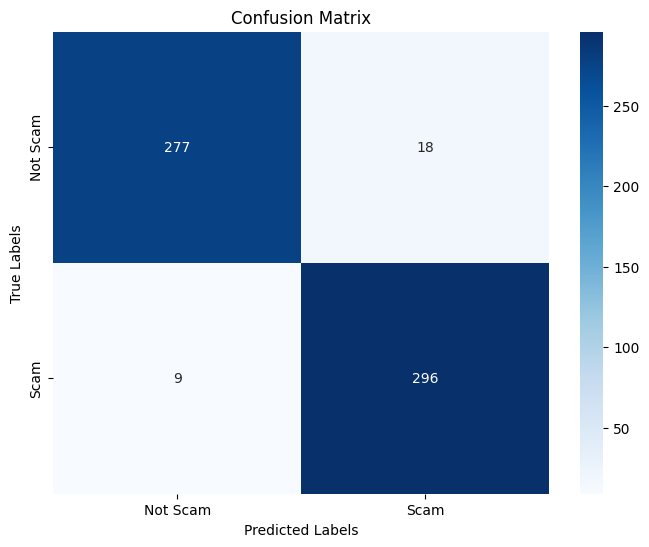

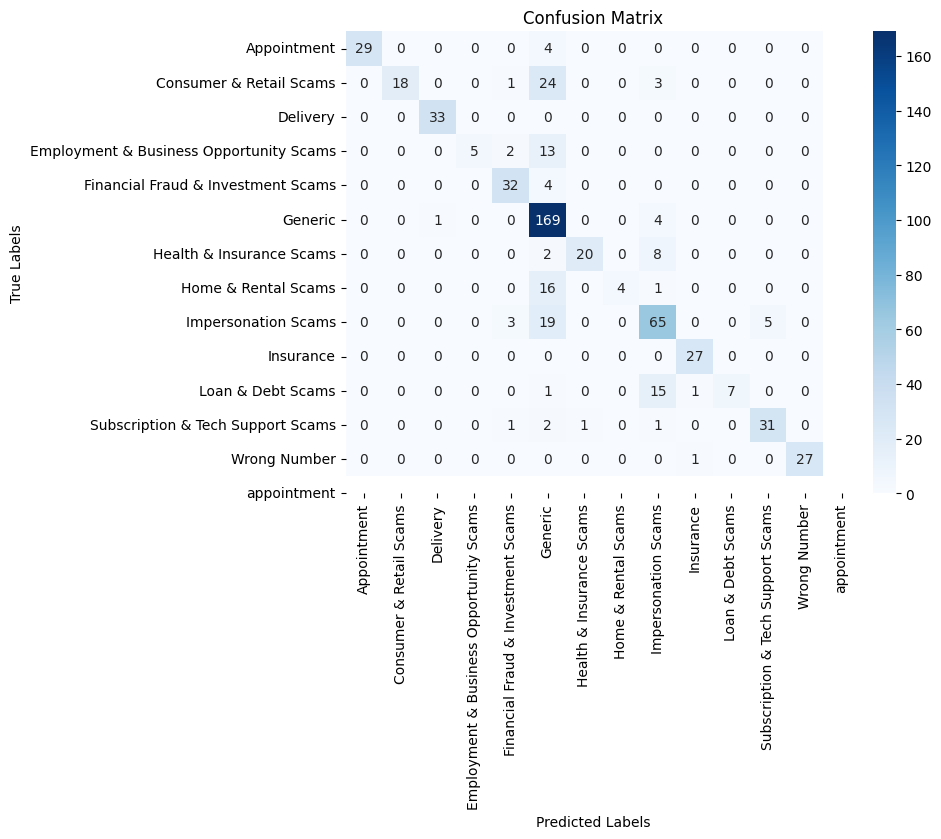

In [38]:
y1_logistic_model.plot_confusion_matrix(X_val, y1_val, ["Not Scam", "Scam"])

y2_logistic_model.plot_confusion_matrix(X_val, y2_val, le.classes_)

### Logistic Regression on the test set

Validating class distribution on the test set. As seen below, they are almost evenly distributed.

In [39]:
print("Label:\n", pd.Series(y1_test).value_counts())
print("\n")
print("Type:\n", pd.Series(y2_test).value_counts())

Label:
 labels
1    318
0    282
Name: count, dtype: int64


Type:
 5     163
8      94
4      49
11     46
9      39
1      37
6      30
12     30
0      30
7      24
3      21
2      20
10     17
Name: count, dtype: int64


Test Set Metrics (Likeliness of Scam, Y1):

Accuracy: 0.9450
Precision: 0.9553
Recall: 0.9403
F1 Score: 0.9477

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       282
           1       0.96      0.94      0.95       318

    accuracy                           0.94       600
   macro avg       0.94      0.95      0.94       600
weighted avg       0.95      0.94      0.95       600



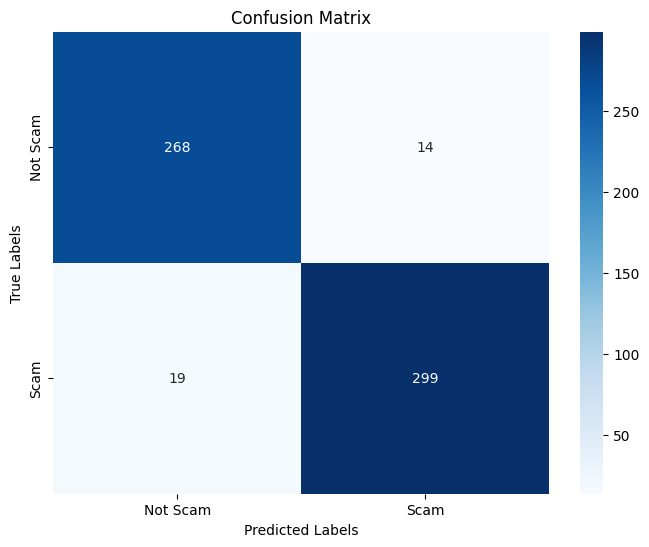

Test Set Metrics (Type of Scam, Y2):

Accuracy: 0.8133
Precision: 0.8423
Recall: 0.8133
F1 Score: 0.7923

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       0.94      0.46      0.62        37
           2       0.83      1.00      0.91        20
           3       1.00      0.29      0.44        21
           4       0.95      0.86      0.90        49
           5       0.69      0.99      0.81       163
           6       0.85      0.57      0.68        30
           7       0.75      0.12      0.21        24
           8       0.79      0.87      0.83        94
           9       0.95      1.00      0.97        39
          10       1.00      0.35      0.52        17
          11       0.95      0.83      0.88        46
          12       1.00      1.00      1.00        30

    accuracy                           0.81       600
   macro avg       0.90      0.71      0.75       600
weigh

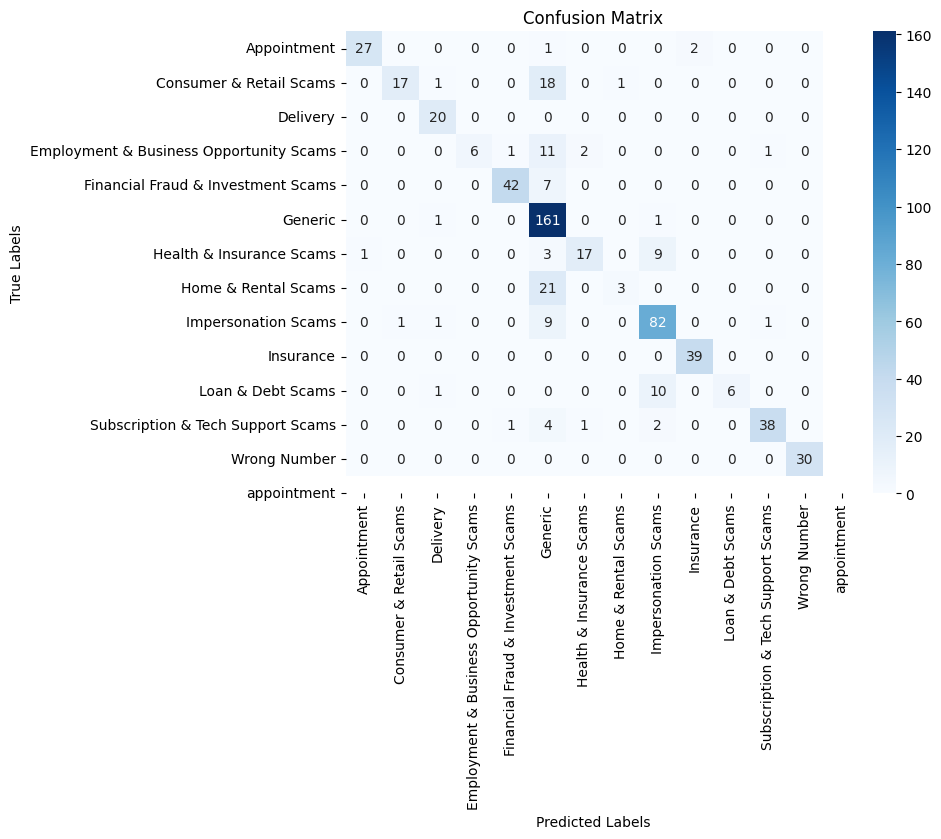

In [40]:
# Make predictions on the test set
y1_test_pred = y1_logistic_model.predict(X_test)
y1_test_accuracy, y1_test_precision, y1_test_recall, y1_test_f1, y1_test_conf_matrix, y1_test_class_report = y1_logistic_model.evaluate(X_test, y1_test)

# Print metrics
print(f"Test Set Metrics (Likeliness of Scam, Y1):\n")
print(f"Accuracy: {y1_test_accuracy:.4f}")
print(f"Precision: {y1_test_precision:.4f}")
print(f"Recall: {y1_test_recall:.4f}")
print(f"F1 Score: {y1_test_f1:.4f}")
print("\nClassification Report:")
print(y1_test_class_report)

# Plot confusion matrix
y1_logistic_model.plot_confusion_matrix(X_test, y1_test, ["Not Scam", "Scam"])

# Make predictions on the test set
y2_test_pred = y2_logistic_model.predict(X_test)
y2_test_accuracy, y2_test_precision, y2_test_recall, y2_test_f1, y2_test_conf_matrix, y2_test_class_report = y2_logistic_model.evaluate(X_test, y2_test)

# Print metrics
print(f"Test Set Metrics (Type of Scam, Y2):\n")
print(f"Accuracy: {y2_test_accuracy:.4f}")
print(f"Precision: {y2_test_precision:.4f}")
print(f"Recall: {y2_test_recall:.4f}")
print(f"F1 Score: {y2_test_f1:.4f}")
print("\nClassification Report:")
print(y2_test_class_report)

# Plot confusion matrix
y2_logistic_model.plot_confusion_matrix(X_test, y2_test, le.classes_)

### Scam Detection with Reinforcement Learning

We will now explore scam detectionn with reinforcement learning - the third main paradigm within the field of machine learning. 

Rather than training our model with an explicit labelled dataset, we train an agent with a policy to maximize scam detection accuracy. With this approach over time, our agent should be able to explore and learn new scam patterns dynamically rather than relying on static labels.

**Key Components:**

- Agent: The model that classifies conversations
- Environment: The dataset of conversations
- State: Features representing the current conversation
- Action: Classifying a conversation as 'scam' or 'not scam'
- Reward: Feedback based on the accuracy of the classification

Use Transformers-based feature extractor with SentenceBERT

In [83]:
from sentence_transformers import SentenceTransformer 

model = SentenceTransformer('all-MiniLM-L6-v2').to(device)
X_rl = list(dataset_df["dialogue_processed"].values)
X_rl_embeddings = model.encode(X_rl)

In [84]:
y_rl = dataset_df["labels"].values

In [85]:
print(X_rl_embeddings.shape)
print(y_rl.shape)

(5820, 384)
(5820,)


In [93]:
X_rl_train, X_rl_rest, y_rl_train, y_rl_rest = train_test_split(X_rl_embeddings, y_rl, test_size=0.6, random_state=42) # Train split
X_rl_val, X_rl_test, y_rl_val, y_rl_test = train_test_split(X_rl_rest, y_rl_rest, test_size=0.5, random_state=42) # Validation and test split

In [97]:
print("Train set:")
print(X_rl_train.shape)
print(y_rl_train.shape)
print()
print("Validation set:")
print(X_rl_val.shape)
print(y_rl_val.shape)
print()
print("Test set:")
print(X_rl_test.shape)
print(y_rl_test.shape)

Train set:
(2328, 384)
(2328,)

Validation set:
(1746, 384)
(1746,)

Test set:
(1746, 384)
(1746,)


Use TF-IDF with 5-grams

In [74]:
# TODO

Use Word2Vec

In [75]:
# TODO

Defining the Neural Network (Agent + Policy that it follows)

In [210]:
import torch.nn as nn
import torch.optim as optim

class ScamPolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(ScamPolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        # Here we manually define how the network is connected, without using "sequential"
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1) 
    
    # Architecture is like
    # Input dim (384 for sentenceBERT, 200 for tf-idf) -> FC1 -> ReLU -> FC2 -> Softmax
    # FC1 to learn features from input
    # ReLU to prevent vanishing gradients
    # FC2 to get linear outputs for both classes (scam, not scam), then use softmax to get probabilities

Reward Function

In [211]:
def reward_function(pred, true_label):
    if pred == true_label:
        return 1  # Correct classification
    elif pred == 1 and true_label == 0:
        return -1  # False positive penalty
    elif pred == 0 and true_label == 1:
        return -2  # False negative penalty

Train the RL model policy

In [212]:
policy_net = ScamPolicyNetwork(input_dim=X_rl_embeddings.shape[1]).to(device)

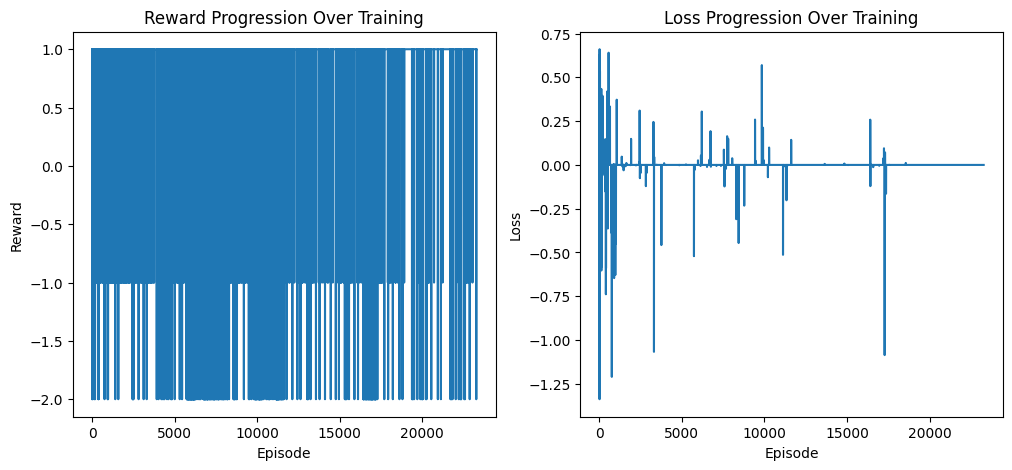

In [213]:
import matplotlib.pyplot as plt

optimizer = optim.Adam(policy_net.parameters(), lr=0.02)

reward_history = []
loss_history = []

num_epochs = 10

for epoch in range(num_epochs):  # Train over multiple epochs
    for feature, label in zip(X_rl_train, y_rl_train):  # Iterate over all training samples
        
        state = torch.tensor(feature, dtype=torch.float32).to(device) 
        probs = policy_net(state) # Agent will output the actions (probabilities)
        action = torch.argmax(probs).item() # Select action with highest probability
        
        reward = reward_function(action, label) # Compute reward
        
        loss = -torch.log(probs[action]) * reward  # Loss function will be amplified by the reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        reward_history.append(reward)
        loss_history.append(loss.item())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward Progression Over Training")

plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Loss Progression Over Training")

plt.show()

Test Model on Validation Set

In [214]:
policy_net.eval()  # Set to evaluation mode
correct, total = 0, 0

for state, y_true in zip(X_rl_val, y_rl_val):
    # state = extract_features(state)  # Convert text to embeddings
    state = torch.tensor(state, dtype=torch.float32).to(device)
    probs = policy_net(state)  # Get action probabilities
    action = torch.argmax(probs).item()  # Select the highest probability action

    if action == y_true:
        correct += 1
    total += 1

accuracy = correct / total
print(f"Validation Set Accuracy: {accuracy:.4f}")

Validation Set Accuracy: 0.9817


In [215]:
policy_net.eval()  # Set to evaluation mode
correct, total = 0, 0

for state, y_true in zip(X_rl_test, y_rl_test):
    # state = extract_features(state)  # Convert text to embeddings
    state = torch.tensor(state, dtype=torch.float32).to(device)
    probs = policy_net(state)  # Get action probabilities
    action = torch.argmax(probs).item()  # Select the highest probability action

    if action == y_true:
        correct += 1
    total += 1

accuracy = correct / total
print(f"Test Set Accuracy: {accuracy:.4f}")

Test Set Accuracy: 0.9822


Compute Precision Recall and F1

In [216]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = []
y_true = []

for state, label in zip(X_rl_test, y_rl_test):
    # state = extract_features(state)
    state = torch.tensor(state, dtype=torch.float32).to(device)
    probs = policy_net(state)
    action = torch.argmax(probs).item()

    y_pred.append(action)
    y_true.append(label)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9749
Recall: 0.9896
F1 Score: 0.9822


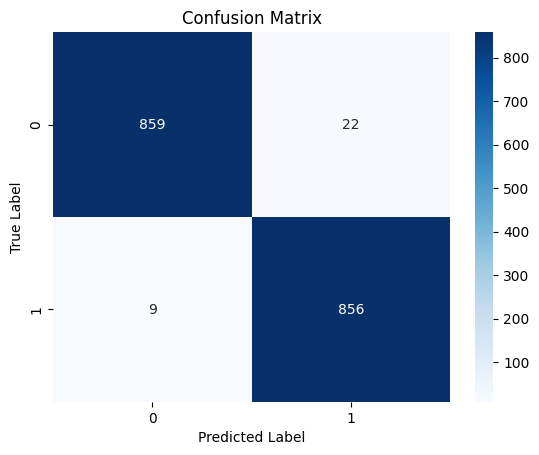

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Multi Task Learning - Training and Evaluation

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Custom Dataset Class for Multi-Task Learning
1. **Embedding Features**: BERT embeddings for caller and recipient texts.
2. **Labels**: Binary classification labels for scam detection. Float32 is used here for BCE loss.
3. **Types**: Categorical labels for scam type classification. Int64 is used here for CrossEntropy loss.

In [27]:
class MultiTaskDataset(Dataset):
    def __init__(self, embedding, labels, types):
        self.X = torch.tensor(embedding, dtype=torch.float32)
        # For binary task, we use float labels
        self.labels = torch.tensor(labels.values if hasattr(labels, "values") else labels, dtype=torch.float32)
        # For multi-class, targets should be long (integer encoded)
        self.types = torch.tensor(types.values if hasattr(types, "values") else types, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx], self.types[idx]

### Multi-Task Learning Model Architecture

The model processes input features through shared layers and then splits into two separate heads for different tasks: one for binary classification and another for multi-class classification.

```mermaid
flowchart LR
    input[Input Features] -- 1536(from BERT) --> shared

    subgraph shared[Shared Layers]
        direction TB
        fc1[Linear Layer<br/>in: <br/>] -- 512 --> relu[ReLU] --> dropout[Dropout<br/>p=0.2]
    end

    shared -- 512 --> label_head[Label Head<br/>Linear Layer]
    shared -- 512 --> type_head[Type Head<br/>Linear Layer]

    label_head -- 1 --> label_out[Label Logits<br/>Binary Classification]
    type_head -- 12(from the number_types) --> type_out[Type Logits<br/>Multi-class Classification]
```

In this architecture:

* Shared Layers: Extract features from the input using a linear layer, ReLU, and dropout.
* Binary Head: Produces a single logit for binary classification.
* Multi-class Head: Produces logits for each class in a multi-class setting.

In [28]:
class MultiTaskNet(nn.Module):
    def __init__(self, feature_dimension, num_types):
        super(MultiTaskNet, self).__init__()
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(feature_dimension, 512),
            nn.ReLU(),
            nn.Dropout(0.2) # Regularization for preventing overfitting
        )
        # Head for binary scam label prediction
        self.label_head = nn.Linear(512, 1)  # output logit for binary classification
        
        # Head for multi-class scam type prediction
        self.type_head = nn.Linear(512, num_types)
    
    def forward(self, x):
        shared_rep = self.shared(x)
        # For binary classification, we’ll use BCEWithLogitsLoss, so no sigmoid here.
        label_logits = self.label_head(shared_rep)
        # For type classification, output logits (to be used with CrossEntropyLoss)
        type_logits = self.type_head(shared_rep)
        return label_logits, type_logits

### Multi-Task Learning Model

1. **Loss Functions**:
   - **Binary Classification**: Binary Cross-Entropy Loss
   - **Multi-class Classification**: Cross-Entropy Loss
2. **Optimizer**: Adam Optimizer with a default learning rate of 0.001


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader

class MutltiTaskModel:
    def __init__(self, X_train, y1_train, y2_train, num_types, batch_size=32, lr=1e-3):
        self.model = MultiTaskNet(X_train.shape[1], num_types)

        # Determine device (cuda, mps, or cpu)
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
        else:
            self.device = torch.device("cpu")
        self.model.to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion_label = nn.BCEWithLogitsLoss()
        self.criterion_type = nn.CrossEntropyLoss()
        self.batch_size = batch_size

        # Create DataLoader for training
        self.train_dataset = MultiTaskDataset(X_train, y1_train, y2_train)
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)

        # Lists to store losses for plotting
        self.train_label_losses = []
        self.train_type_losses = []
        
        # For saving the best model
        self.best_model_weights = None
    
    def summary(self):
        """
        Prints the model summary.
        """
        self.model.to("cpu")
        summary(self.model, (self.batch_size, X_train.shape[1]))
        self.model.to(self.device)

    def train(self, num_epochs):
        best_loss = float('inf')

        for epoch in range(num_epochs):
            self.model.train()
            total_loss_label = 0.0
            total_loss_type = 0.0
            num_batches = 0
            
            for inputs, labels, types in self.train_loader:
                inputs, labels, types = inputs.to(self.device), labels.to(self.device), types.to(self.device)
                
                self.optimizer.zero_grad()
                label_logits, type_logits = self.model(inputs)
                
                loss_label = self.criterion_label(label_logits.view(-1), labels)
                loss_type = self.criterion_type(type_logits, types)
                
                loss = loss_label + loss_type
                loss.backward()
                self.optimizer.step()
                
                total_loss_label += loss_label.item()
                total_loss_type += loss_type.item()
                num_batches += 1
            
            # Calculate average loss for the epoch
            avg_loss_label = total_loss_label / num_batches
            avg_loss_type = total_loss_type / num_batches
            total_loss = avg_loss_label + avg_loss_type
            
            # Store losses for plotting
            self.train_label_losses.append(avg_loss_label)
            self.train_type_losses.append(avg_loss_type)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}")
                print(f"Average Loss (Label): {avg_loss_label:.4f}")
                print(f"Average Loss (Type): {avg_loss_type:.4f}")
                print(f"Total Loss: {total_loss:.4f}\n")
            
            # Save best model weights
            if total_loss < best_loss:
                best_loss = total_loss
                self.best_model_weights = self.model.state_dict()
                
        print("Training complete.")

    def plot_losses(self):
        """
        Plots the losses for label and type predictions during training.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_label_losses, label="Label Loss")
        plt.plot(self.train_type_losses, label="Type Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Losses")
        plt.legend()
        plt.show()

    def predict(self, X):
        """
        Makes predictions for the given inputs X.
        
        Parameters:
            X (numpy array or tensor): Input features.
        
        Returns:
            tuple: (predicted_label, predicted_type) where predicted_label is the binary prediction (0 or 1)
                   and predicted_type is the predicted class for multi-class task.
        """
        self.model.eval()
        with torch.no_grad():
            inputs = torch.tensor(X, dtype=torch.float32).to(self.device)
            label_logits, type_logits = self.model(inputs)
            label_pred = (torch.sigmoid(label_logits) >= 0.5).cpu().numpy().astype(int) # Convert to 0 or 1 instead of floating point from sigmoid
            type_pred = torch.argmax(type_logits, dim=1).cpu().numpy()
        
        return label_pred, type_pred

    def evaluate(self, X, y1, y2):
        """
        Evaluates the model on the provided dataset and computes various performance metrics.
        
        Parameters:
            X (array-like): Input features.
            y1 (array-like): True labels for binary classification.
            y2 (array-like): True labels for multi-class classification.
        
        Returns:
            tuple: A nested tuple containing:
                - accuracy (float): Overall accuracy of the model.
                - precision (float): Precision score.
                - recall (float): Recall score.
                - f1 (float): F1 score.
                - conf_matrix (array-like): Confusion matrix.
                - class_report (str): Text summary of the precision, recall, and f1-score for each class.
        """
        y1_pred, y2_pred = self.predict(X)
        
        # Binary classification metrics
        accuracy_label = accuracy_score(y1, y1_pred)
        precision_label = precision_score(y1, y1_pred, zero_division=0)
        recall_label = recall_score(y1, y1_pred, zero_division=0)
        f1_label = f1_score(y1, y1_pred, zero_division=0)
        conf_matrix_label = confusion_matrix(y1, y1_pred)
        
        # Multi-class classification metrics
        accuracy_type = accuracy_score(y2, y2_pred)
        precision_type = precision_score(y2, y2_pred, average='weighted', zero_division=0)
        recall_type = recall_score(y2, y2_pred, average='weighted', zero_division=0)
        f1_type = f1_score(y2, y2_pred, average='weighted', zero_division=0)
        conf_matrix_type = confusion_matrix(y2, y2_pred)
        
        return (accuracy_label, precision_label, recall_label, f1_label, conf_matrix_label), \
               (accuracy_type, precision_type, recall_type, f1_type, conf_matrix_type)
    
    def plot_confusion_matrix(self, X, y1, y2, labels):
        """
        Plots the confusion matrix for the model's predictions.
        
        Parameters:
            X (array-like): Input features.
            y1 (array-like): True labels for binary classification.
            y2 (array-like): True labels for multi-class classification.
            labels (list): List of label names to be used in the plot axes.
        """
        y1_pred, y2_pred = self.predict(X)
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(confusion_matrix(y1, y1_pred), annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Scam", "Scam"], yticklabels=["Not Scam", "Scam"])
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Binary Classification")
        
        plt.subplot(1, 2, 2)
        sns.heatmap(confusion_matrix(y2, y2_pred), annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Multi-Class Classification")
        
        plt.tight_layout()
        plt.show()

#### Training the Multi-Task Learning Model

- The model is trained for **5 epochs** with a batch size of **32**.
- **Binary Classification** and **Multi-class Classification** losses are computed separately.

In [31]:
multi_task_model = MutltiTaskModel(X_train, y1_train, y2_train, num_types, batch_size=32, lr=1e-3)

In [32]:
multi_task_model.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 512]         393,728
              ReLU-2              [-1, 32, 512]               0
           Dropout-3              [-1, 32, 512]               0
            Linear-4                [-1, 32, 1]             513
            Linear-5               [-1, 32, 14]           7,182
Total params: 401,423
Trainable params: 401,423
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.38
Params size (MB): 1.53
Estimated Total Size (MB): 2.00
----------------------------------------------------------------


In [33]:
multi_task_model.train(100)

Epoch 1/100
Average Loss (Label): 0.6126
Average Loss (Type): 2.0838
Total Loss: 2.6964

Epoch 11/100
Average Loss (Label): 0.0873
Average Loss (Type): 0.3005
Total Loss: 0.3878

Epoch 21/100
Average Loss (Label): 0.0362
Average Loss (Type): 0.1078
Total Loss: 0.1439

Epoch 31/100
Average Loss (Label): 0.0232
Average Loss (Type): 0.0579
Total Loss: 0.0811

Epoch 41/100
Average Loss (Label): 0.0116
Average Loss (Type): 0.0334
Total Loss: 0.0450

Epoch 51/100
Average Loss (Label): 0.0056
Average Loss (Type): 0.0242
Total Loss: 0.0298

Epoch 61/100
Average Loss (Label): 0.0040
Average Loss (Type): 0.0172
Total Loss: 0.0212

Epoch 71/100
Average Loss (Label): 0.0044
Average Loss (Type): 0.0090
Total Loss: 0.0134

Epoch 81/100
Average Loss (Label): 0.0039
Average Loss (Type): 0.0067
Total Loss: 0.0106

Epoch 91/100
Average Loss (Label): 0.0017
Average Loss (Type): 0.0053
Total Loss: 0.0070

Training complete.


### Loss Graphs

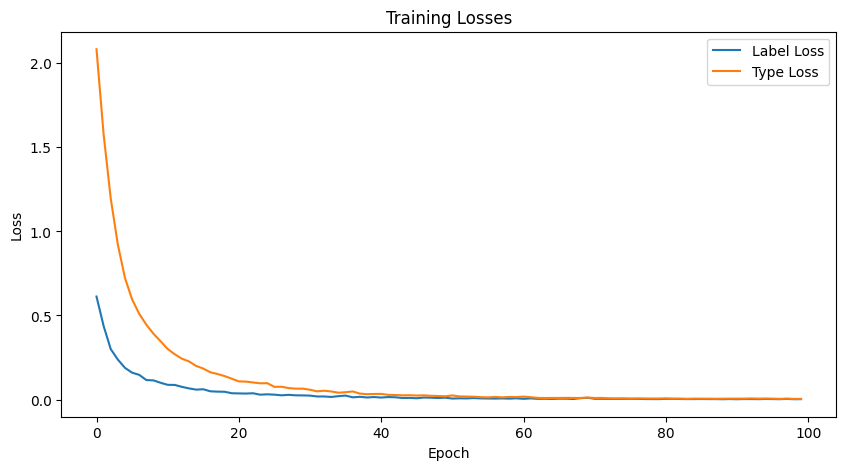

In [34]:
multi_task_model.plot_losses()

### Model Evaluation on the Validation Set

Validation Set Metrics:
Binary Classification:
Accuracy: 0.9833
Precision: 0.9773
Recall: 0.9902
F1 Score: 0.9837

Multi-Class Classification:
Accuracy: 0.9617
Precision: 0.9634
Recall: 0.9617
F1 Score: 0.9608


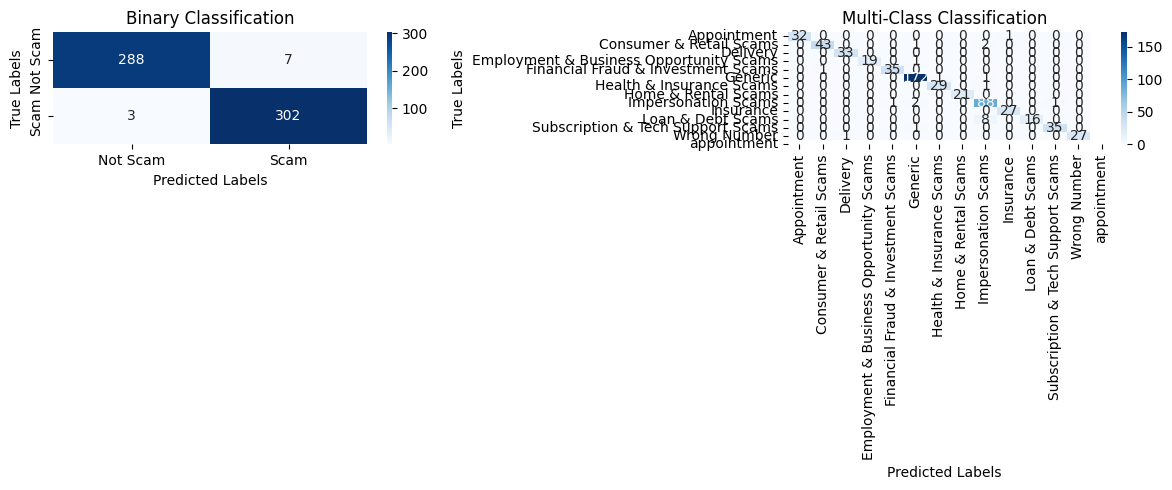

In [35]:
pred_label, pred_type = multi_task_model.predict(X_val)

eval_label, eval_type = multi_task_model.evaluate(X_val, y1_val, y2_val)

print("Validation Set Metrics:")
print(f"Binary Classification:")
print(f"Accuracy: {eval_label[0]:.4f}")
print(f"Precision: {eval_label[1]:.4f}")
print(f"Recall: {eval_label[2]:.4f}")
print(f"F1 Score: {eval_label[3]:.4f}")

print("\nMulti-Class Classification:")
print(f"Accuracy: {eval_type[0]:.4f}")
print(f"Precision: {eval_type[1]:.4f}")
print(f"Recall: {eval_type[2]:.4f}")
print(f"F1 Score: {eval_type[3]:.4f}")

multi_task_model.plot_confusion_matrix(X_val, y1_val, y2_val, le.classes_)


### Model Evaluation on the Test Set

Test Set Metrics:
Binary Classification:
Accuracy: 0.9994
Precision: 1.0000
Recall: 0.9988
F1 Score: 0.9994

Multi-Class Classification:
Accuracy: 0.9811
Precision: 0.9814
Recall: 0.9811
F1 Score: 0.9804


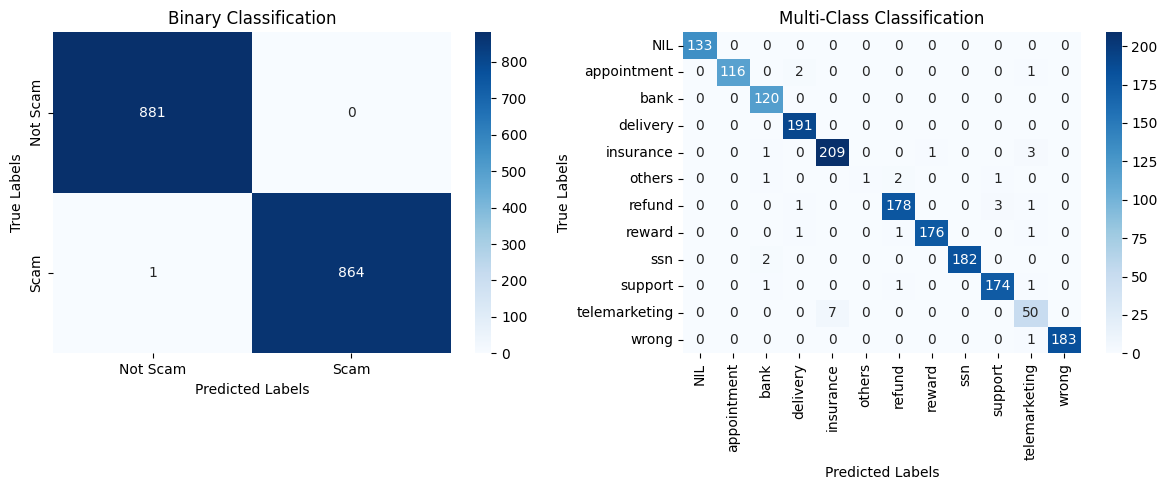

In [65]:
pred_label, pred_type = multi_task_model.predict(X_test)

eval_label, eval_type = multi_task_model.evaluate(X_test, y1_test, y2_test)

print("Test Set Metrics:")
print(f"Binary Classification:")
print(f"Accuracy: {eval_label[0]:.4f}")
print(f"Precision: {eval_label[1]:.4f}")
print(f"Recall: {eval_label[2]:.4f}")
print(f"F1 Score: {eval_label[3]:.4f}")

print("\nMulti-Class Classification:")
print(f"Accuracy: {eval_type[0]:.4f}")
print(f"Precision: {eval_type[1]:.4f}")
print(f"Recall: {eval_type[2]:.4f}")
print(f"F1 Score: {eval_type[3]:.4f}")

multi_task_model.plot_confusion_matrix(X_test, y1_test, y2_test, le.classes_)


### Ensemble Learning Models

First, import modules

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier

import math

#### AdaBoost Classifier

AdaBoost Accuracy (Y1): 0.9500
Precision (Y1): 0.9508
Recall (Y1): 0.9500
F1 Score (Y1): 0.9500

AdaBoost Accuracy (Y2): 0.5550
Precision (Y2): 0.5574
Recall (Y2): 0.5550
F1 Score (Y2): 0.5028


c:\Users\Fooyo\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


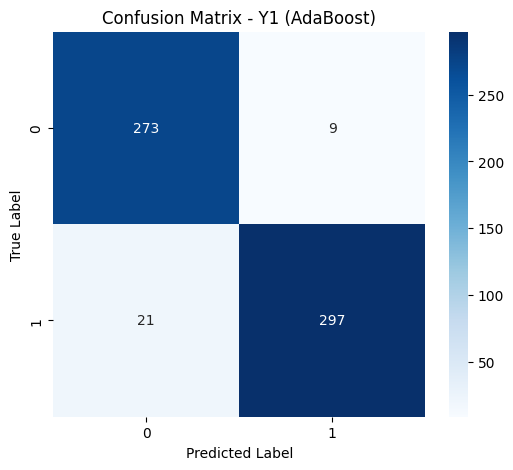

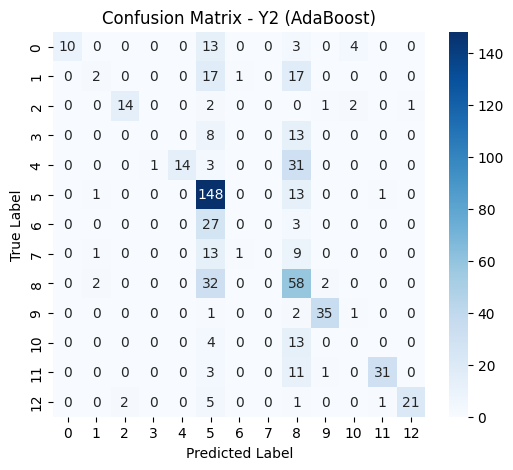

In [62]:
# Initialize AdaBoost Model
AdaBoost = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train and Evaluate for Y1
AdaBoost.fit(X_train, y1_train)
y1_pred = AdaBoost.predict(X_test)

# Calculate metrics for Y1
y1_accuracy = accuracy_score(y1_test, y1_pred)
y1_precision = precision_score(y1_test, y1_pred, average="weighted")
y1_recall = recall_score(y1_test, y1_pred, average="weighted")
y1_f1 = f1_score(y1_test, y1_pred, average="weighted")

print(f"AdaBoost Accuracy (Y1): {y1_accuracy:.4f}")
print(f"Precision (Y1): {y1_precision:.4f}")
print(f"Recall (Y1): {y1_recall:.4f}")
print(f"F1 Score (Y1): {y1_f1:.4f}")

# Train and Evaluate for Y2
AdaBoost.fit(X_train, y2_train)
y2_pred = AdaBoost.predict(X_test)

# Calculate metrics for Y2
y2_accuracy = accuracy_score(y2_test, y2_pred)
y2_precision = precision_score(y2_test, y2_pred, average="weighted")
y2_recall = recall_score(y2_test, y2_pred, average="weighted")
y2_f1 = f1_score(y2_test, y2_pred, average="weighted")

print(f"\nAdaBoost Accuracy (Y2): {y2_accuracy:.4f}")
print(f"Precision (Y2): {y2_precision:.4f}")
print(f"Recall (Y2): {y2_recall:.4f}")
print(f"F1 Score (Y2): {y2_f1:.4f}")

# Confusion Matrix Function
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot Confusion Matrices
plot_conf_matrix(y1_test, y1_pred, "Confusion Matrix - Y1 (AdaBoost)")
plot_conf_matrix(y2_test, y2_pred, "Confusion Matrix - Y2 (AdaBoost)")


#### Random Forest Classfier

In [ ]:
RandomForest = RandomForestClassifier(
    n_estimators=100, random_state=42, max_depth=100 , oob_score=True, bootstrap=True
)

# Train and evaluate for Y1
RandomForest.fit(X_train, y1_train)
y1_pred = RandomForest.predict(X_test)
y1_balanced_accuracy = balanced_accuracy_score(y1_test, y1_pred)
y1_accuracy = accuracy_score(y1_test, y1_pred)
y1_precision = precision_score(y1_test, y1_pred, average="weighted")
y1_recall = recall_score(y1_test, y1_pred, average="weighted")
y1_f1 = f1_score(y1_test, y1_pred, average="weighted")

print(f"Random Forest Accuracy (Y1): {y1_accuracy:.4f}")
print(f"Balanced Accuracy (Y1): {y1_balanced_accuracy:.4f}")
print(f"Precision (Y1): {y1_precision:.4f}")
print(f"Recall (Y1): {y1_recall:.4f}")
print(f"F1 Score (Y1): {y1_f1:.4f}")

# Train and evaluate for Y2
RandomForest.fit(X_train, y2_train)
y2_pred = RandomForest.predict(X_test)
y2_accuracy = accuracy_score(y2_test, y2_pred)
y2_balance_accuracy = balanced_accuracy_score(y2_test, y2_pred)
y2_precision = precision_score(y2_test, y2_pred, average="weighted")
y2_recall = recall_score(y2_test, y2_pred, average="weighted")
y2_f1 = f1_score(y2_test, y2_pred, average="weighted")

print(f"\nRandom Forest Accuracy (Y2): {y2_accuracy:.4f}")
print(f"Balanced Accuracy (Y2): {y2_balance_accuracy:.4f}")
print(f"Precision (Y2): {y2_precision:.4f}")
print(f"Recall (Y2): {y2_recall:.4f}")
print(f"F1 Score (Y2): {y2_f1:.4f}")

# Confusion Matrix Function
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot Confusion Matrices
plot_conf_matrix(y1_test, y1_pred, "Confusion Matrix - Y1")
plot_conf_matrix(y2_test, y2_pred, "Confusion Matrix - Y2")
